<a href="https://colab.research.google.com/github/tomonari-masada/course2021-stats2/blob/main/02_PyMC_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. PyMC3入門
* 今回、PyMC3を解説するに当たっては、PyMC3の公式サイトを参考にした。
 * https://docs.pymc.io/notebooks/api_quickstart.html

## 2.0 準備

### 2.0.1 インストール
* arviz関係のエラーが出たら、ランタイムを再起動して、そこから上のセルを実行し直す。

In [ ]:
!pip install arviz==0.10

In [ ]:
!pip install pymc3==3.8

### 2.0.2 復習：ベイズ的モデリングにおけるベイズ則
* $X$を観測データ、$\theta$を観測データをモデル化する確率分布のパラメータとする。
$$ p(\theta | X) = \frac{ p(X | \theta) p(\theta) }{ p(X) } $$
* ベイズ的モデリングでは、事後分布$p(\theta | X)$を知ることが目標。
 * MCMCは、事後分布から得たサンプルを通して事後分布の姿を知ろうとする時に使う。
 * 変分ベイズ推論は、事後分布を近似する代替物としての別の扱いやすい分布を通して事後分布の姿を知ろうとする時に使う。

## 2.1 PyMC3でモデルを作る

### 2.1.1 PyMC3における確率変数

* とりあえずPyMC3をインポートする。
 * エラーが出たらランタイムを再起動するなどしてみる。

In [ ]:
import numpy as np
import pymc3 as pm

* PyMC3では、いきなり確率変数を作ることはできない。
 * パラメータが1の指数分布に従う確率変数を作ろうとして、下のセルを実行すると、エラーが出るはず。

In [ ]:
# lambda_ = pm.Exponential("poisson_param", 1)

* 確率変数は、いきなり作るのではなく、必ずモデルの中で作る。
 * あらかじめ空のインスタンスを作っておき、「with model:」というブロックを書くか、
 * いきなり「with pm.Model() as model:」というブロックを書くかの、いずれか。

In [ ]:
model = pm.Model()
with model:
    lambda_ = pm.Exponential("poisson_param", 1)

In [ ]:
with pm.Model() as model:
    lambda_ = pm.Exponential("poisson_param", 1)

* 下のモデルは、まず、平均パラメータが0で標準偏差パラメータが1の正規分布に従うunobservedな確率変数muを持っている。
 * この正規分布は、平均パラメータが従う事前分布。
* そして、平均パラメータが確率変数muで標準偏差パラメータが1の正規分布に従うobservedな確率変数obsを持っている。
 * この正規分布は、データを直接モデリングする確率分布。
* さらに、観測データとして、正規乱数として生成した100個の数値を指定している。
---
* このベイズ的なモデルを数式で書くと・・・
$$ \mu \sim N(0, 1) $$
$$ x \sim N(\mu, 1) $$



In [ ]:
model = pm.Model()
with model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

* notebook環境では、確率変数がどんな分布に従うかを簡単に確認できる。

In [ ]:
mu

mu

In [ ]:
model.named_vars["mu"]

mu

In [ ]:
obs

obs

In [ ]:
model.named_vars["obs"]

obs

* PyMC3の確率変数(RV: random variable)には以下の2種類がある。
cf. https://docs.pymc.io/api/variables.html


1.   Free (= Unobserved) RVs that a model is specified in terms of. 
2.   Observed RVs that a model is specified in terms of. Potentially partially observed.



In [ ]:
model.free_RVs

[mu]

In [ ]:
model.observed_RVs

[obs]

* `basic_RVs`: List of random variables the model is defined in terms of (which excludes deterministics)
 * deterministicsについては後で説明。

In [ ]:
model.basic_RVs

[mu, obs]

### 2.1.2 log probabilityの計算

* 観測データを100個指定しているので、muを特定の値に固定することでlog probabilityを計算することができる。
 * `logp`は、後で見るように、同時分布$p(X,\theta)$の密度関数の対数を表す。

In [ ]:
model.logp({"mu": 0})

array(-150.77379442)

* 下のように変数の文字列の名前ではなく、変数を直接指定しても、同じ意味になる。

In [ ]:
model.logp({mu: 0})

array(-150.77379442)

* モデルに属するそれぞれの確率変数は、適当な初期値を設定されている。
 * この初期値は、サンプリングの出発点として用いられる。

In [ ]:
mu.tag.test_value

0.0

In [ ]:
obs.tag.test_value

array([-3.32631993e-01, -8.14471512e-01,  9.63064871e-01,  2.00536074e+00,
       -7.16022782e-01,  1.20856844e+00, -1.10088237e-01, -7.38472077e-01,
       -2.39822437e-01,  3.09948753e-01,  1.46137713e+00, -5.80558873e-01,
        1.39549687e-01,  1.75534941e+00, -8.24988106e-01,  7.35909215e-01,
        1.41615335e+00,  1.74629968e-02, -2.83137769e+00, -1.27097466e+00,
       -1.46443692e+00, -9.18357075e-01, -1.15271585e-02,  2.77272138e-01,
        5.95435473e-01, -1.55719800e+00, -4.63349310e-01,  1.12688621e+00,
        1.23233390e+00, -1.08657848e+00, -3.15237632e-01, -9.10346570e-01,
       -2.39192980e-01,  1.90302636e+00, -1.20852484e-02,  7.78431698e-01,
       -6.58038251e-02,  4.87559077e-01, -2.76306605e+00, -9.73605716e-01,
       -7.68075560e-01, -2.32153522e+00, -5.88537127e-02, -4.92778689e-01,
       -5.43695659e-01, -1.09868103e+00, -4.93270259e-01,  3.50282831e-01,
       -8.59690484e-01,  1.26412860e-02, -2.21420642e+00,  1.16219458e+00,
       -1.21344910e+00, -

* 観測されている確率変数の初期値は、設定された観測データと同じ値になっているようだ。

In [ ]:
obs.observations

array([-3.32631993e-01, -8.14471512e-01,  9.63064871e-01,  2.00536074e+00,
       -7.16022782e-01,  1.20856844e+00, -1.10088237e-01, -7.38472077e-01,
       -2.39822437e-01,  3.09948753e-01,  1.46137713e+00, -5.80558873e-01,
        1.39549687e-01,  1.75534941e+00, -8.24988106e-01,  7.35909215e-01,
        1.41615335e+00,  1.74629968e-02, -2.83137769e+00, -1.27097466e+00,
       -1.46443692e+00, -9.18357075e-01, -1.15271585e-02,  2.77272138e-01,
        5.95435473e-01, -1.55719800e+00, -4.63349310e-01,  1.12688621e+00,
        1.23233390e+00, -1.08657848e+00, -3.15237632e-01, -9.10346570e-01,
       -2.39192980e-01,  1.90302636e+00, -1.20852484e-02,  7.78431698e-01,
       -6.58038251e-02,  4.87559077e-01, -2.76306605e+00, -9.73605716e-01,
       -7.68075560e-01, -2.32153522e+00, -5.88537127e-02, -4.92778689e-01,
       -5.43695659e-01, -1.09868103e+00, -4.93270259e-01,  3.50282831e-01,
       -8.59690484e-01,  1.26412860e-02, -2.21420642e+00,  1.16219458e+00,
       -1.21344910e+00, -

* 下のセルの計算で、`model.logp({"mu": 0})`と同じ答えを得ることができているのは、なぜか。説明してみよう。

In [ ]:
import numpy as np
from scipy.stats import norm

print(np.log(norm().pdf(obs.observations)).sum() + np.log(norm().pdf(0)))

-150.77379442384571


* 確率変数の初期値は、以下のようにして手動で設定することもできる。

In [ ]:
with model:
    parameter = pm.Exponential("poisson_param", 1.0, testval=0.5)

print("parameter.tag.test_value =", parameter.tag.test_value)

parameter.tag.test_value = 0.5


* 同じ分布に従う複数の確率変数を一挙に作ることもできる。
* 確率変数のリストを作ることは推奨されていない。
 * cf. https://docs.pymc.io/notebooks/api_quickstart.html#Lists-of-RVs-/-higher-dimensional-RVs
* キーワード引数shapeで個数(or 形)を指定する方法が推奨されている。

In [ ]:
with pm.Model():
    # bad:
    x = [pm.Normal(f"x_{i}", mu=0, sigma=1) for i in range(10)]

In [ ]:
with pm.Model() as model:
    # good:
    x = pm.Normal("x", mu=0, sigma=1, shape=10)

In [ ]:
x.tag.test_value

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## 2.2 PyMC3で使える確率分布
cf. https://docs.pymc.io/notebooks/api_quickstart.html#2.-Probability-Distributions

### 2.2.1 PyMC3におけるprobabilistic programの構成
* どんなprobabilistic programも、観測確率変数と潜在確率変数とから成る。
 * 観測確率変数は、尤度分布によって定義される。
 * 潜在確率変数は、事前分布によって定義される。


* PyMC3で使える分布は、以下の通り。
 * 単変量連続分布 https://docs.pymc.io/api/distributions/continuous.html
 * 単変量離散分布 https://docs.pymc.io/api/distributions/discrete.html
 * 多変量分布 https://docs.pymc.io/api/distributions/multivariate.html
 * 混合分布　https://docs.pymc.io/api/distributions/mixture.html

* `help`関数で各分布の説明を見ることができる。

In [ ]:
help(pm.Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Normal(name, *args, **kwargs)
 |  
 |  Univariate normal log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(-5, 5, 1000)
 |      mus = [0., 0., 0., -2.]
 |      sigmas = [0.4, 1., 2., 0.4]
 |      for mu, sigma in zip(mus, sigmas):
 |          pdf = st.norm.pdf(x, mu, sigma)
 |          plt.plot(x, pdf, labe

* 確率変数が従う分布の密度関数の対数を評価することもできる。

In [ ]:
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1)

In [ ]:
eval_points = np.linspace(-5.0, 5.0, 11)
print(eval_points)

[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


In [ ]:
np.exp(x.distribution.logp(eval_points).eval())

array([1.48671951e-06, 1.33830226e-04, 4.43184841e-03, 5.39909665e-02,
       2.41970725e-01, 3.98942280e-01, 2.41970725e-01, 5.39909665e-02,
       4.43184841e-03, 1.33830226e-04, 1.48671951e-06])

In [ ]:
np.exp(model.named_vars["x"].distribution.logp(eval_points).eval())

array([1.48671951e-06, 1.33830226e-04, 4.43184841e-03, 5.39909665e-02,
       2.41970725e-01, 3.98942280e-01, 2.41970725e-01, 5.39909665e-02,
       4.43184841e-03, 1.33830226e-04, 1.48671951e-06])

### 2.2.2 確率変数のdeterministic transform
* 観測確率変数でも潜在確率変数でもないものとして、確率変数のdeterministic transformsがある。
* これは、他の確率変数を、加減乗除の計算を行ったり、自分で定義した関数を適用するなどして、変換したもののことである。

In [ ]:
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    summed = x + y
    squared = x ** 2
    sined = pm.math.sin(x)

* 変換した後の変数は`basic_RVs`には含まれない。

In [ ]:
model.basic_RVs

[x, y_log__]

* `y_log__`とあるのは、確率変数`y`については、その値の対数をとったものが内部的には表現されているから。
 * ガンマ分布に従う確率変数は、デフォルトの設定ではこのように扱われる。

In [ ]:
y

y

In [ ]:
summed

Elemwise{add,no_inplace}.0

In [ ]:
 summed.eval({x:0, y:1})

array(1.)

* 変換した後の変数がとる値もPyMC3にちゃんと追跡させるようにするには、`pm.Deterministic`を使って明示的に変換する。

In [ ]:
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1)
    plus_2 = x + 2
    plus_2_det = pm.Deterministic("x plus 2", x + 2)

In [ ]:
model.basic_RVs

[x]

In [ ]:
plus_2

Elemwise{add,no_inplace}.0

In [ ]:
plus_2.eval({x:3})

array(5.)

In [ ]:
plus_2_det

x plus 2

In [ ]:
model.deterministics

[x plus 2]

In [ ]:
plus_2_det.eval({x:3})

array(5.)

### 2.2.3 確率変数の自動的な変換(transform)
* 上に示した、ガンマ分布に従う確率変数の場合のように、デフォルトの設定で自動的に変換される変数がある。

* 例えば、範囲の決まった連続一様分布に従う確率変数は、`LogOdds`変換が自動的に適用されている。

In [ ]:
with pm.Model() as model:
    x = pm.Uniform("x", lower=0, upper=1)

In [ ]:
model.free_RVs

[x_interval__]

* `x`は、`x_interval__`にロジスティック変換（`LogOdds`変換の逆）を適用したものとして扱われている。

In [ ]:
model.deterministics

[x]

* このように自動的な変換が適用されるのは、変換した後の空間でのサンプリングのほうが容易なためである。

### 2.2.4 変数変換の利用例：変換を明示的に指定することで対数正規分布に従う確率変数を作る

* PyMC3の`pymc3.distributions.transforms.ElemwiseTransform`クラスを継承して、自前の変数変換`Exp`を定義する。
 * これは、変数に指数関数を適用する変換である。

In [ ]:
import theano.tensor as tt # PyMC3でのテンソル型 cf. https://docs.pymc.io/PyMC3_and_Theano.html
import pymc3.distributions.transforms as tr

class Exp(tr.ElemwiseTransform):
    name = "exp"

    def backward(self, x):
        return tt.log(x)

    def forward(self, x):
        return tt.exp(x)

    def jacobian_det(self, x):
        return -tt.log(x)

* 正規分布に従う確率変数に指数関数を適用すると、その値は対数正規分布に従う。
 * `x1`は、この変数変換を使って対数正規分布に従う確率変数として作られている。
 * `x2`は、PyMC3に初めから用意されている対数正規分布に従う確率変数として作られている。

In [ ]:
with pm.Model() as model:
    x1 = pm.Normal("x1", 0.0, 1.0, transform=Exp())
    x2 = pm.Lognormal("x2", 0.0, 1.0)

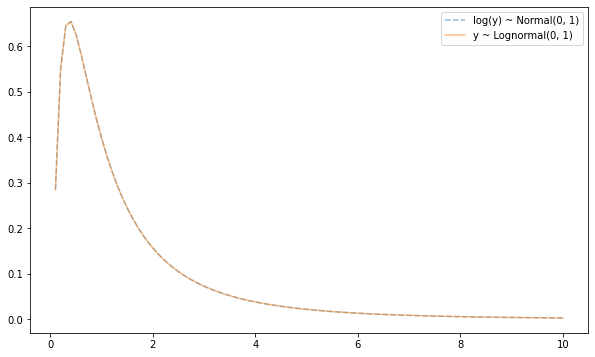

In [ ]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

figsize(10, 6)

lognorm1 = model.named_vars["x1_exp__"]
lognorm2 = model.named_vars["x2"]

_, ax = plt.subplots(1, 1)
x = np.linspace(0.0, 10.0, 100)
ax.plot(
    x,
    np.exp(lognorm1.distribution.logp(x).eval()),
    "--",
    alpha=0.5,
    label="log(y) ~ Normal(0, 1)",
)
ax.plot(
    x,
    np.exp(lognorm2.distribution.logp(x).eval()),
    alpha=0.5,
    label="y ~ Lognormal(0, 1)",
)
plt.legend()

## 2.3 PyMC3における推論

### 2.3.1 サンプリング

### 2.3.2 サンプリング結果の分析

### 2.3.3 変分推論